In [1]:
import numpy as np
import scipy as sp
import scipy.stats.qmc as qmc
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
sp.__version__

'1.7.1'

In [3]:
rng =  np.random.default_rng()

# Exploring smaller bootstrap samples

In [4]:
def f(x):
    x1 = x[:,0]
    x2 = x[:,1]
    return x1**2 + x2**2


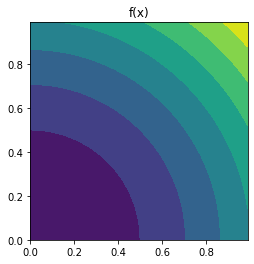

In [5]:
x = np.arange(0, 1, 0.01)
y = np.arange(0, 1, 0.01)
xx,yy = np.meshgrid(x,y)
xy = np.stack([xx.flatten(),yy.flatten()], axis=-1)
z = f(xy)
z = z.reshape(x.shape[0],y.shape[0])
h = plt.contourf(x, y, z)
plt.axis('scaled')
plt.title("f(x)")
plt.show()

In [6]:
# Analytic first and second moments

In [7]:
# Uniform sampling

d   = 2 # number of dimensions

m   = 9
N   = 2**9 # number of samples

samples_uniform  = rng.uniform(size=(N,d))

sampler = qmc.Sobol(d=d,scramble=True)
samples_sobol = sampler.random_base2(m=m)

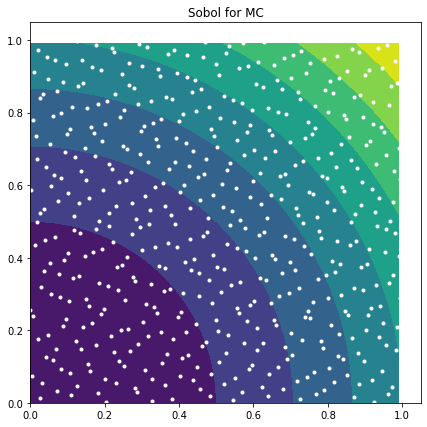

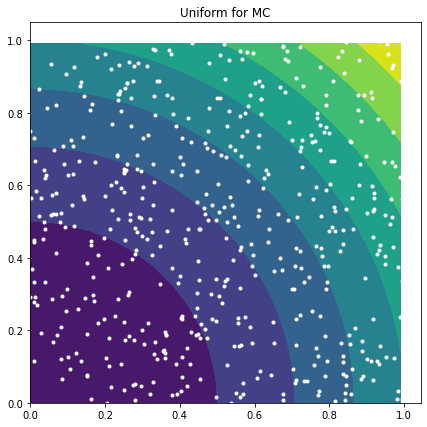

In [8]:
samples_sobol.shape, samples_uniform.shape

plt.figure(figsize=(7,7))
plt.title('Sobol for MC')
h = plt.contourf(x, y, z)
plt.plot( samples_sobol[:,0], samples_sobol[:,1], '.', label='Sobol', c="white")
plt.show()

plt.figure(figsize=(7,7))
plt.title('Uniform for MC')
h = plt.contourf(x, y, z)
plt.plot( samples_uniform[:,0], samples_uniform[:,1], '.', label='Uniform', c="white")
plt.show()

In [10]:
np.mean(f(samples_sobol)), np.mean(f(samples_uniform))

(0.666668095484348, 0.6680811823237625)

In [11]:
np.var(f(samples_sobol)), np.var(f(samples_uniform))

(0.17780638011741612, 0.19407823936954094)

In [12]:
# Uniform sampling

d   = 2 # number of dimensions
m   = 9
N   = 2**6 # number of samples

def get_uniform_samples():
    return rng.uniform(size=(N,d))

def get_sobol_samples():
    sampler = qmc.Sobol(d=d,scramble=True)
    return sampler.random_base2(m=m)

sobol_means = [np.mean(f(get_sobol_samples())) for i in range(100)]
uniform_means = [np.mean(f(get_uniform_samples())) for i in range(100)]



In [13]:
sobol_means = [get_sobol_samples() for i in range(100)]


In [17]:
sobol_means[0][:,0]

array([0.52989087, 0.46482438, 0.11095457, 0.92675519, 0.84542257,
       0.16097702, 0.26435784, 0.69904536, 0.68352515, 0.37359369,
       0.2079301 , 0.76713175, 0.9421531 , 0.00159686, 0.41774896,
       0.60805988, 0.58214283, 0.39207605, 0.05771106, 0.99851143,
       0.79217905, 0.23273328, 0.31660974, 0.62629706, 0.73575038,
       0.30081871, 0.15471327, 0.83891469, 0.88893628, 0.07337979,
       0.46997422, 0.53528488, 0.55564255, 0.49766159, 0.08593741,
       0.89318329, 0.82015848, 0.12765032, 0.28986445, 0.73212969,
       0.65386939, 0.33684808, 0.23685566, 0.80460775, 0.97132176,
       0.03883148, 0.38833442, 0.57107097, 0.61180431, 0.42882362,
       0.02878357, 0.96102971, 0.76300466, 0.19549672, 0.34602624,
       0.66329169, 0.70999682, 0.26797572, 0.17973618, 0.8724885 ,
       0.91420227, 0.10671224, 0.44446182, 0.50219864, 0.5142982 ,
       0.44899538, 0.09534281, 0.91089189, 0.86087769, 0.17666891,
       0.27983201, 0.71477157, 0.66779178, 0.35809615, 0.19221

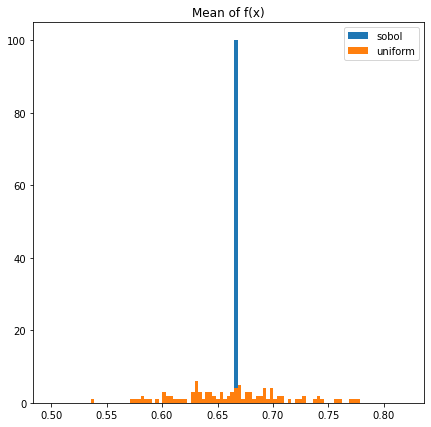

In [133]:
plt.figure(figsize=(7,7))
bins = np.linspace(0.66-0.16,0.66+0.16, 100)
plt.hist(sobol_means, bins, label="sobol")
plt.hist(uniform_means, bins, label="uniform")
plt.title("Mean of f(x)")
plt.legend()


In [134]:
sobol_vars = [np.var(f(get_sobol_samples())) for i in range(100)]
uniform_vars = [np.var(f(get_uniform_samples())) for i in range(100)]

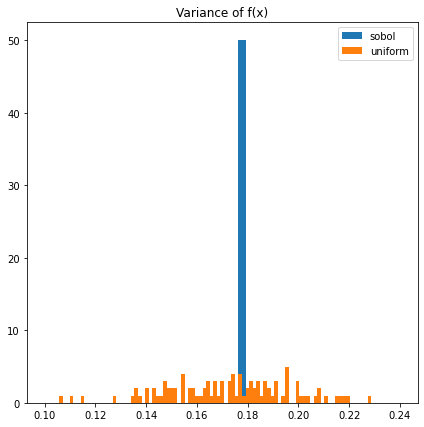

In [135]:
plt.figure(figsize=(7,7))
bins = np.linspace(0.17-0.07,0.17+0.07, 100)
plt.hist(sobol_vars, bins, label="sobol")
plt.hist(uniform_vars, bins, label="uniform")
plt.title("Variance of f(x)")
plt.legend()


## Is the bias in the variance estimator caused by gaussian sampling?

In [9]:
engine = qmc.MultivariateNormalQMC(mean=[0.5,0.5], cov=[[0.2**2, 0], [0, 0.2**2]])
qmc_samples = engine.random(N)

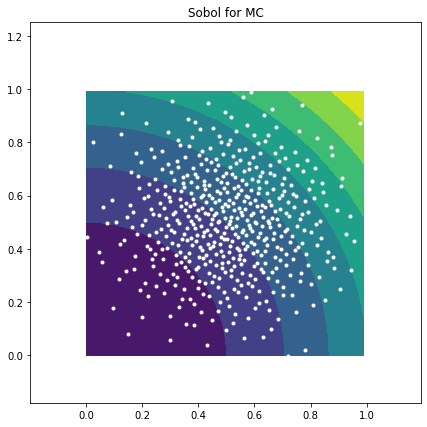

In [10]:
qmc_samples

plt.figure(figsize=(7,7))
plt.title('Sobol for MC')
h = plt.contourf(x, y, z)
plt.plot( qmc_samples[:,0], qmc_samples[:,1], '.', label='Gaussian Sobol', c="white")
plt.show()


Text(0.5, 1.0, 'x')

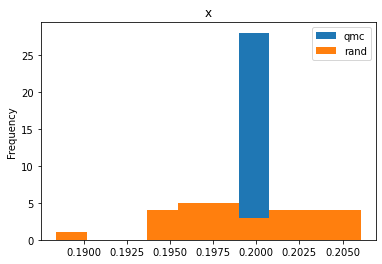

In [24]:
results = []

for trial in range(30):
    engine = qmc.MultivariateNormalQMC(mean=[0.5,0.5], cov=[[0.2**2, 0], [0, 0.2**2]])
    qmc_samples = engine.random(N)
    random_samples = np.random.normal(0.5,0.2,size=(N,2))
    results.append({
        "qmc":qmc_samples.std(),
        "rand":random_samples.std()
    })

pd.DataFrame(results).plot.hist()
plt.title("x")

Text(0.5, 1.0, 'f(x)')

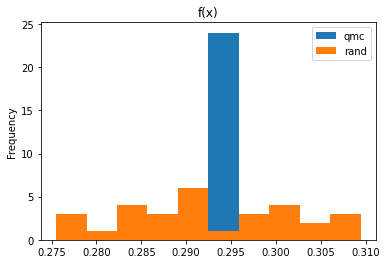

In [22]:
results = []

for trial in range(30):
    engine = qmc.MultivariateNormalQMC(mean=[0.5,0.5], cov=[[0.2**2, 0], [0, 0.2**2]])
    qmc_samples = engine.random(N)
    random_samples = np.random.normal(0.5,0.2,size=(N,2))
    results.append({
        "qmc":f(qmc_samples).std(),
        "rand":f(random_samples).std()
    })

pd.DataFrame(results).plot.hist()
plt.title("f(x)")

## Transforming the uniform [0,1] sobol sequence into different distrubutions

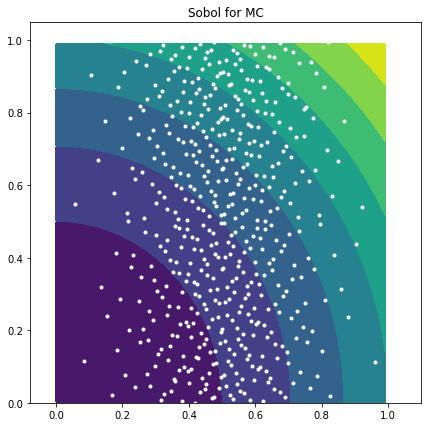

In [45]:
samples_uniform  = rng.uniform(size=(N,d))

sampler = qmc.Sobol(d=d,scramble=True)
samples_sobol = sampler.random_base2(m=m)

samples_sobol[:,0] = scipy.stats.norm.ppf(0.5 + (1 - 1e-10) * (samples_sobol[:,0] - 0.5))
samples_sobol[:,0] = samples_sobol[:,0]*(0.4**2) +0.5

plt.figure(figsize=(7,7))
plt.title('Sobol for MC')
h = plt.contourf(x, y, z)
plt.plot( samples_sobol[:,0], samples_sobol[:,1], '.', label='Sobol', c="white")
plt.show()

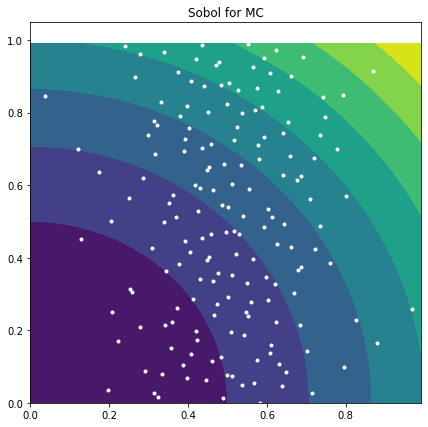

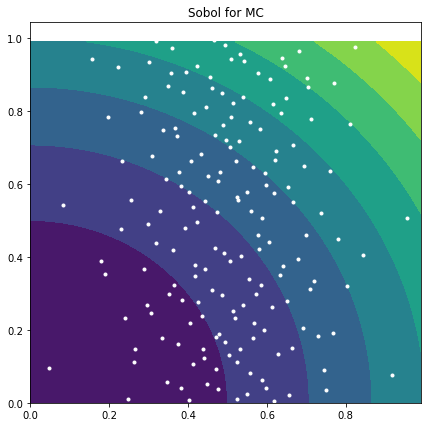

In [54]:
# Can we extract uniform for some variables and gaussian for others?

d=3

samples_uniform  = rng.uniform(size=(N,d))

sampler = qmc.Sobol(d=d,scramble=True)
samples_sobol = sampler.random_base2(m=m)

samples_sobol[:,0] = scipy.stats.norm.ppf(0.5 + (1 - 1e-10) * (samples_sobol[:,0] - 0.5))
samples_sobol[:,0] = samples_sobol[:,0]*(0.4**2) +0.5

samples_sobol[:,2] = np.floor(samples_sobol[:,2]*3)

samps = samples_sobol[samples_sobol[:,2]==0]
plt.figure(figsize=(7,7))
plt.title('Sobol for MC')
h = plt.contourf(x, y, z)
plt.plot( samps[:,0], samps[:,1], '.', label='Sobol', c="white")
plt.show()

samps = samples_sobol[samples_sobol[:,2]==1]
plt.figure(figsize=(7,7))
plt.title('Sobol for MC')
h = plt.contourf(x, y, z)
plt.plot( samps[:,0], samps[:,1], '.', label='Sobol', c="white")
plt.show()

(array([171.,   0.,   0.,   0.,   0., 170.,   0.,   0.,   0., 171.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

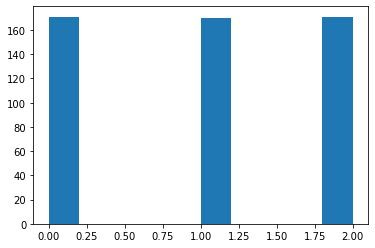

In [52]:
plt.hist(samples_sobol[:,2])

## What effect does seed have on the qmc generator?

The seed is used to set the location of the first point in the sequence randomly.
All subsequent points are generated based on a deterministic algorithm.

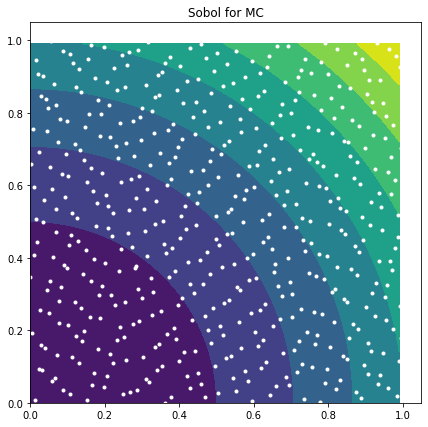

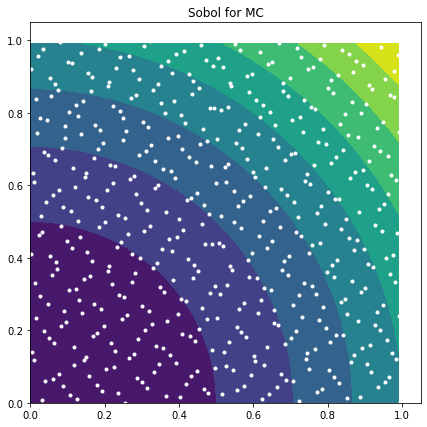

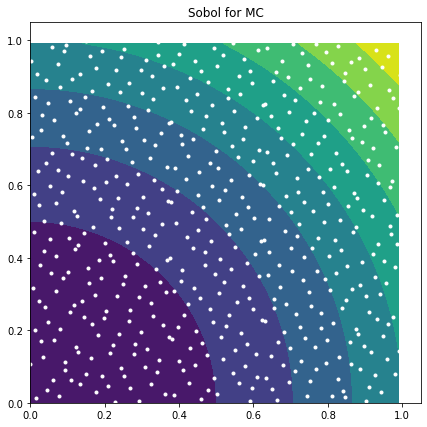

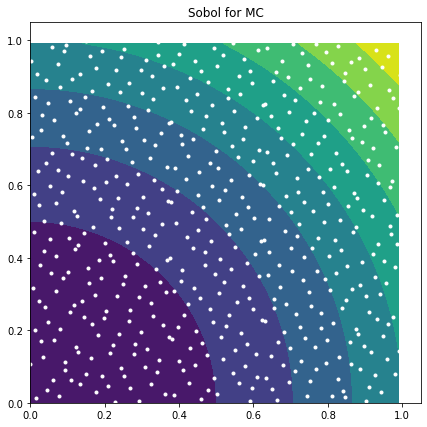

In [25]:


d=2

samples_uniform  = rng.uniform(size=(N,d))

sampler = qmc.Sobol(d=d,scramble=True)
samples_sobol_1 = sampler.random_base2(m=m)

sampler = qmc.Sobol(d=d,scramble=True)
samples_sobol_2 = sampler.random_base2(m=m)

sampler = qmc.Sobol(d=d,scramble=True, seed=11)
samples_sobol_3 = sampler.random_base2(m=m)

sampler = qmc.Sobol(d=d,scramble=True, seed=11)
samples_sobol_4 = sampler.random_base2(m=m)

for samps in [samples_sobol_1, samples_sobol_2, samples_sobol_3, samples_sobol_4]:
    plt.figure(figsize=(7,7))
    plt.title('Sobol for MC')
    h = plt.contourf(x, y, z)
    plt.plot( samps[:,0], samps[:,1], '.', label='Sobol', c="white")
    plt.show()